In [0]:
# # The below are wrapper functions used to connect to your drive and this needs to be run once (i.e. once every new session or possibily refreshes for every 24 hours)

# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse

# # Authentication for your google drive
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()

# # Authentication for the wrapper libraries  or possibily refreshes for every 24 hours)

# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse


# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
# !mkdir -p MyDrive
# !google-drive-ocamlfuse MyDrive
# %cd ML/AIML_Labs/

In [3]:
%cd MyDrive/ML/AIML_Labs/FinalHackathon

/content/MyDrive/ML/AIML_Labs/FinalHackathon


In [0]:
# # http://pytorch.org/
# from os import path
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

# accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
# import torch

In [34]:
#@title Default title text
!pip uninstall torchvision

Uninstalling torchvision-0.2.1:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/torchvision-0.2.1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/torchvision/*
Proceed (y/n)? ^C
Operation cancelled by user


In [33]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

tcmalloc: large alloc 1073750016 bytes == 0x5c750000 @  0x7f6b402c51c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
0.3.0.post4
True


In [23]:
# Importing pytorch packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

# Importing config.py file
# import config as cf
# from utils import *
## Importing python packages
import os
import sys
import time
import datetime
import numpy as np
import math
import matplotlib.pyplot as plt
import copy

from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

# import config as cf
from utils import *
from data_loader import *



ModuleNotFoundError: ignored

In [18]:
!ls

car_turns.ipynb  Data_Description.pdf  Lab11-Experiment2_2.ipynb  utils.py
config.py	 data_loader.py        signs_data


In [0]:
def training_curves(file_):
    train_loss = [line.rstrip('\n') for line in open(file_+'train_loss.txt')]
    train_loss_hist = []
    train_acc_hist = []

    for loss in train_loss:
        train_loss_hist += [float(loss.split(' ')[1])]
        train_acc_hist += [100-float(loss.split(' ')[2])]


    val_loss = [line.rstrip('\n') for line in open(file_+'val_loss.txt')]
    val_loss_hist = []
    val_acc_hist = []
    for loss in val_loss:
        val_loss_hist += [float(loss.split(' ')[1])]
        val_acc_hist += [100-float(loss.split(' ')[2])]
    
    print(len(train_loss_hist), len(val_loss_hist))

    fig, ax1 = plt.subplots()
    ax1.plot(train_loss_hist,  'C0--', alpha=0.5, label='train_loss')
    ax1.plot(val_loss_hist, 'C0-', alpha=0.5, label='val_loss', linewidth=2.0)
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel('cross entropy loss')
    ax1.tick_params('y')
    ax2 = ax1.twinx()
    ax2.plot(train_acc_hist, 'C1--', alpha=0.5, label='train_error')
    ax2.plot(val_acc_hist, 'C1-', alpha=0.5, label='val_error', linewidth=2.0)
    ax2.set_ylabel('Error')
    ax2.tick_params('y')
    ax1.legend(loc='upper center')
    ax2.legend(loc='best')
    fig.tight_layout()
    plt.show()

def param_counts(net):
    count = 0
    for parameter in net.parameters():
        c = 1
        for dim in parameter.size():
            c = c*dim
        count += c
    return count

term_width = int(80)

TOTAL_BAR_LENGTH = 35.
last_time = time.time()
begin_time = last_time
def progress_bar(current, total, msg=None):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH*current/total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time

    L = []
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)
    for i in range(term_width-int(TOTAL_BAR_LENGTH)-len(msg)-3):
        sys.stdout.write(' ')

    # Go back to the center of the bar.
    for i in range(term_width-int(TOTAL_BAR_LENGTH/2)+2):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current+1, total))

    if current < total-1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()

def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds*1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f


In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

NUM_CLASSES = 6

In [0]:
data_dir = 'signs_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_cuda = torch.cuda.is_available()

In [8]:
# image_datasets['train'].classes
# dir(dataloaders['train'])
class_names

['left', 'misc', 'right', 'signal', 'stop', 'u_turn']

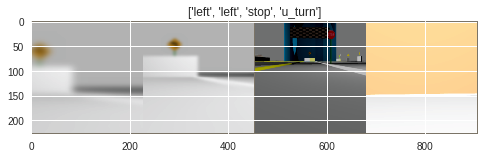

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)
                if use_cuda:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
                if phase == 'train':
#                     print(type(model), type(inputs))
                    inputs, labels = Variable(inputs), Variable(labels)
#                     inputs, labels = Variable(inputs), labels
  
#                     outputs = model(torch.squeeze(Variable(inputs)))
                    outputs = model(inputs)                    
                    _, preds = torch.max(outputs, 1)
                    size_ = outputs.size()
                    outputs_ = outputs.view(size_[0], NUM_CLASSES)
                    loss = criterion(outputs_, labels)

                    # backward + optimize only if in training phase
#                     if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
            
#                 running_loss += loss.item() * inputs.size(0)
                running_loss += loss.data[0] * inputs.size(0)   
#                 print(preds.size(), labels.size())
#                 running_corrects += torch.sum(preds == labels)
#                 running_corrects += (preds == labels).cpu().sum()
                print(type(preds), type(labels))
                try:
                  preds_np = preds.data.cpu().numpy()
                  labels_np = labels.data.cpu().numpy()
                  running_corrects += (preds_np == labels_np).sum()
                except:
                    print('********* BAD ************* ', type(preds), type(labels))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = float(running_corrects) / dataset_sizes[phase]

#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(
#                 phase, epoch_loss, epoch_acc))
            print('Phase =', phase, 'Epoch Loss = ', epoch_loss, 'Epoch Acc = ', epoch_acc)
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
# def train(model, criterion, optimizer, scheduler, epochs=25):
#     print('\nEpoch: %d' % epoch)
#     feature_net.train()
#     train_loss = 0
#     correct = 0
#     total = 0
#     for batch_idx, (inputs, targets) in enumerate(trainloader):
#         if use_cuda:
#             inputs, targets = inputs.cuda(), targets.cuda()
#         optimizer.zero_grad()
#         inputs, targets = Variable(inputs), Variable(targets)
#         outputs = feature_net(inputs)      ### notice that the pre-trained network has an implant classifier which directly outputs the 16 class prediction scores

        
#         size_ = outputs.size()
#         outputs_ = outputs.view(size_[0], num_classes)
#         loss = criterion(outputs_, targets)
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.data[0]
#         _, predicted = torch.max(outputs_.data, 1)
#         total += targets.size(0)
#         correct += predicted.eq(targets.data).cpu().sum()
        
#         if batch_idx%10 == 0 or batch_idx == len(trainloader)-1:
#             progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
#                          % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        
#     train_loss_file.write('%d %.3f %.3f\n' %(epoch, train_loss/len(trainloader), 100.*correct/total))

In [11]:
a = np.array([1, 2, 3])
b = np.array([1, 0, 3])

(a == b).sum()


2

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, NUM_CLASSES) 

# model_ft = model_ft.to(device)
if use_cuda:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [32]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.

<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'tor

<class 'torch.autograd.variable.Variable'> <class 'torch.cuda.LongTensor'>
********* BAD *************  <class 'torch.autograd.variable.Variable'> <class 'torch.cuda.LongTensor'>
<class 'torch.autograd.variable.Variable'> <class 'torch.cuda.LongTensor'>
********* BAD *************  <class 'torch.autograd.variable.Variable'> <class 'torch.cuda.LongTensor'>
<class 'torch.autograd.variable.Variable'> <class 'torch.cuda.LongTensor'>
********* BAD *************  <class 'torch.autograd.variable.Variable'> <class 'torch.cuda.LongTensor'>
<class 'torch.autograd.variable.Variable'> <class 'torch.cuda.LongTensor'>
********* BAD *************  <class 'torch.autograd.variable.Variable'> <class 'torch.cuda.LongTensor'>
Phase = val Epoch Loss =  1.9618699550628662 Epoch Acc =  0.0

Epoch 1/24
----------
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.vari

<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'tor

<class 'torch.autograd.variable.Variable'> <class 'torch.cuda.LongTensor'>
********* BAD *************  <class 'torch.autograd.variable.Variable'> <class 'torch.cuda.LongTensor'>
<class 'torch.autograd.variable.Variable'> <class 'torch.cuda.LongTensor'>
********* BAD *************  <class 'torch.autograd.variable.Variable'> <class 'torch.cuda.LongTensor'>
<class 'torch.autograd.variable.Variable'> <class 'torch.cuda.LongTensor'>
********* BAD *************  <class 'torch.autograd.variable.Variable'> <class 'torch.cuda.LongTensor'>
Phase = val Epoch Loss =  1.4928131103515625 Epoch Acc =  0.0

Epoch 2/24
----------
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Va

Process Process-84:
Process Process-82:
Traceback (most recent call last):
Process Process-81:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Process-83:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 42, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 42, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
Traceback (most recent call last):
  File "/usr/local/l

<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>


  File "/usr/local/lib/python3.6/dist-packages/torchvision/datasets/folder.py", line 130, in pil_loader
    return img.convert('RGB')
  File "/usr/local/lib/python3.6/dist-packages/torchvision/datasets/folder.py", line 130, in pil_loader
    return img.convert('RGB')
  File "/usr/local/lib/python3.6/dist-packages/PIL/Image.py", line 879, in convert
    self.load()
  File "/usr/local/lib/python3.6/dist-packages/PIL/Image.py", line 879, in convert
    self.load()
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageFile.py", line 231, in load
    n, err_code = decoder.decode(b)
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageFile.py", line 231, in load
    n, err_code = decoder.decode(b)
KeyboardInterrupt
KeyboardInterrupt


KeyboardInterrupt: ignored

In [0]:
visualize_model(model_ft)

0.3.1


In [23]:
torch.__version__

'0.3.0.post4'